## Introduction:
You can use this ipython notebook as a template for the rest of the homework.

### 0. Basic Useful Setups:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import defaultdict
from torchviz import make_dot

### 1. Load datasets

In [2]:
def getLoaders(batch_size=256, num_workers=4):
    transform = transforms.Compose([
                    transforms.ToTensor(),
                ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                      transform=transform, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    transform=transform, download=True)
    
    trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
    testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                             num_workers=num_workers)
    return trainloader, testloader

### 1. LetNet Model

In [5]:
class LeNet(nn.Module):
    def __init__(self, opt='adam', lr=0.01, momentum=0.7):
        super(LeNet, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #                 padding=0, dilation=1, groups=1, bias=True)
        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1,
        #                    return_indices=False, ceil_mode=False)
        self.layer1 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=20, 
                                    kernel_size=(5, 5), padding=(2, 2)),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.layer2 = nn.Sequential(
                                nn.Conv2d(in_channels=20, out_channels=50, 
                                    kernel_size=(5, 5), padding=(2, 2)),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.fc1 = nn.Linear(in_features=8*8*50, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        
        # Optimizer
        if opt=='adam':
            self.optimizer = optim.Adam(self.parameters())
        elif opt=='adad':
            self.optimizer = optim.Adadelta(self.parameters())
        elif opt=='admx':
            self.optimizer = optim.Adamax(self.parameters())
        elif opt=='sgdm':
            self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 50*8*8)
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out),dim=1)
        return out
    
    def optimize(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.data[0]
    
    def getLoss(self, inputs, labels):
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        return loss.data[0]
    
    def getCorrect(self, inputs, labels):
        outputs = self(inputs)
        _, predicted = torch.max(outputs.data, 1)
        return (predicted == labels.data).sum()

### 2. Train and Evaluate LeNet Model

In [6]:
epochs = 20
trainloader, testloader = getLoaders()

def getVariable(data):
    inputs, labels = data
    return Variable(inputs).cuda(), Variable(labels).cuda()

lenet_losses = defaultdict(lambda : defaultdict(list))
lenet_err = defaultdict(lambda : defaultdict(list))

for opt in ['sgdm','adam','adad','admx']:
    print('Optimizer : ',opt)
    lenet = LeNet(opt)
    lenet.cuda()
    for epoch in range(epochs):
        #print('Starting epoch : ',epoch+1)
        train_loss = 0.0
        train_correct = 0
        n_train = 0
        for i, data in enumerate(trainloader):
            inputs, labels = getVariable(data)
            train_loss += lenet.optimize(inputs, labels)
            train_correct += lenet.getCorrect(inputs, labels)
            n_train += len(labels)

        test_loss = 0.0
        test_correct = 0
        n_test = 0
        for i, data in enumerate(testloader):
            inputs, labels = getVariable(data)
            test_loss += lenet.getLoss(inputs, labels)
            test_correct += lenet.getCorrect(inputs, labels)
            n_test += len(labels)

        #print('Train Loss : ',train_loss/n_train)
        #print('Train Accuracy : ',1.0*train_correct/n_train)
        #print('Test Loss : ',test_loss/n_test)
        #print('Test Accuracy : ',1.0*test_correct/n_test)
        #print('#############################################')
        lenet_losses['train'][opt].append(train_loss/n_train)
        lenet_losses['test'][opt].append(test_loss/n_test)
        lenet_err['train'][opt].append(1.0-1.0*train_correct/n_train)
        lenet_err['test'][opt].append(1.0-1.0*test_correct/n_test)

Files already downloaded and verified
Files already downloaded and verified
('Optimizer : ', 'sgdm')
('Optimizer : ', 'adam')
('Optimizer : ', 'adad')
('Optimizer : ', 'admx')


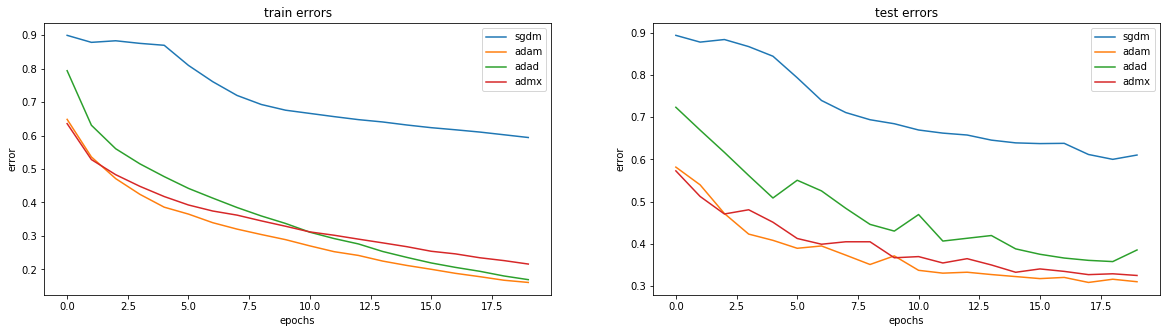

In [7]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,lenet_err[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' errors')
        plt.xlabel('epochs')
        plt.ylabel('error')
plt.show()

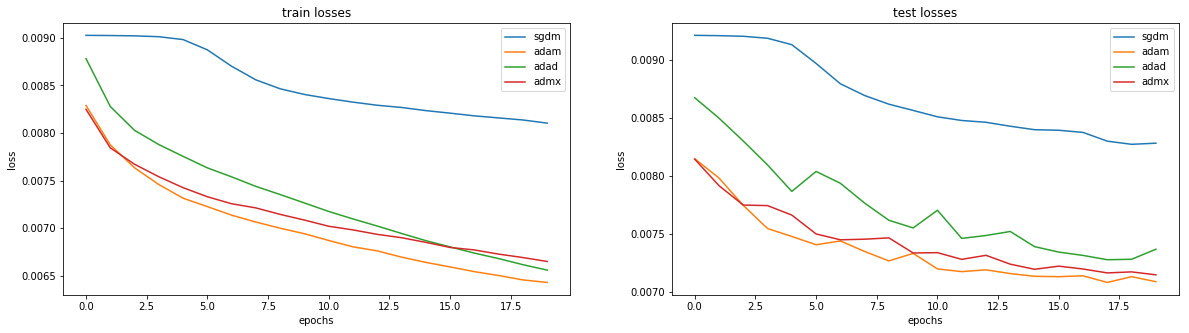

In [8]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,lenet_losses[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' losses')
        plt.xlabel('epochs')
        plt.ylabel('loss')
plt.show()

### 3. My Model

In [9]:
class MyNet(nn.Module):
    def __init__(self, opt='adam', lr=0.01, momentum=0.7):
        super(MyNet, self).__init__()
        self.layer1 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.layer2 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.fc1 = nn.Linear(in_features=8*8*128, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        
        # Optimizer
        if opt=='adam':
            self.optimizer = optim.Adam(self.parameters())
        elif opt=='adad':
            self.optimizer = optim.Adadelta(self.parameters())
        elif opt=='admx':
            self.optimizer = optim.Adamax(self.parameters())
        elif opt=='sgdm':
            self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 128 * 8 * 8)
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out),dim=1)
        return out
    
    def optimize(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.data[0]
    
    def getLoss(self, inputs, labels):
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        return loss.data[0]
    
    def getCorrect(self, inputs, labels):
        outputs = self(inputs)
        _, predicted = torch.max(outputs.data, 1)
        return (predicted == labels.data).sum()

In [10]:
epochs = 20
trainloader, testloader = getLoaders()

def getVariable(data):
    inputs, labels = data
    return Variable(inputs).cuda(), Variable(labels).cuda()

mynet_losses = defaultdict(lambda : defaultdict(list))
mynet_err = defaultdict(lambda : defaultdict(list))

for opt in ['sgdm','adam','adad','admx']:
    print('Optimizer : ',opt)
    mynet = MyNet(opt)
    mynet.cuda()
    for epoch in range(epochs):
        #print('Starting epoch : ',epoch+1)
        train_loss = 0.0
        train_correct = 0
        n_train = 0
        for i, data in enumerate(trainloader):
            inputs, labels = getVariable(data)
            train_loss += mynet.optimize(inputs, labels)
            train_correct += mynet.getCorrect(inputs, labels)
            n_train += len(labels)

        test_loss = 0.0
        test_correct = 0
        n_test = 0
        for i, data in enumerate(testloader):
            inputs, labels = getVariable(data)
            test_loss += mynet.getLoss(inputs, labels)
            test_correct += mynet.getCorrect(inputs, labels)
            n_test += len(labels)

        #print('Train Loss : ',train_loss/n_train)
        #print('Train Accuracy : ',1.0*train_correct/n_train)
        #print('Test Loss : ',test_loss/n_test)
        #print('Test Accuracy : ',1.0*test_correct/n_test)
        #print('#############################################')
        mynet_losses['train'][opt].append(train_loss/n_train)
        mynet_losses['test'][opt].append(test_loss/n_test)
        mynet_err['train'][opt].append(1.0-1.0*train_correct/n_train)
        mynet_err['test'][opt].append(1.0-1.0*test_correct/n_test)

Files already downloaded and verified
Files already downloaded and verified
('Optimizer : ', 'sgdm')
('Optimizer : ', 'adam')
('Optimizer : ', 'adad')
('Optimizer : ', 'admx')


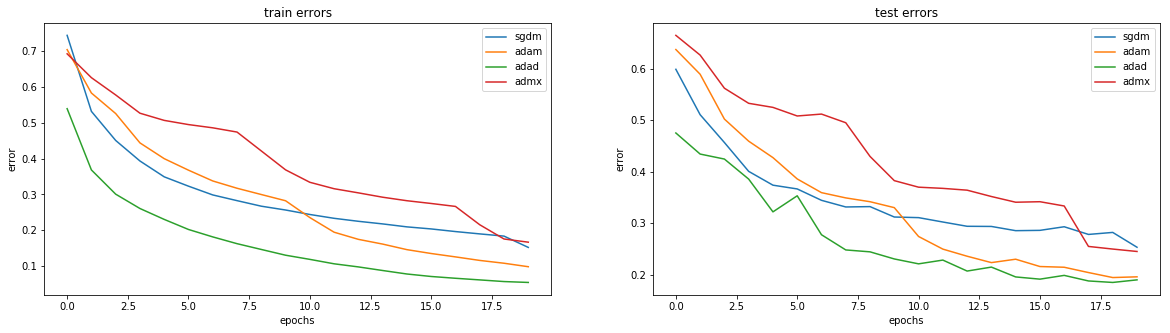

In [12]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,mynet_err[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' errors')
        plt.xlabel('epochs')
        plt.ylabel('error')
plt.show()

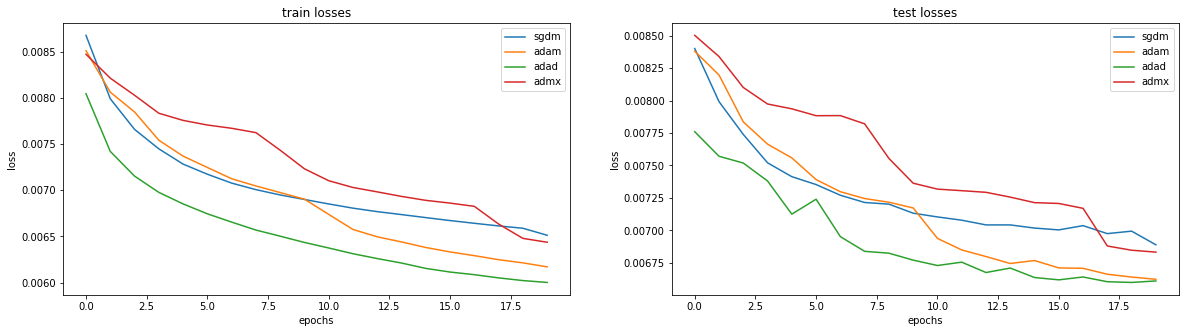

In [13]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,mynet_losses[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' losses')
        plt.xlabel('epochs')
        plt.ylabel('loss')
plt.show()

In [18]:
class MyNet2(nn.Module):
    def __init__(self, opt='adam', lr=0.01, momentum=0.7):
        super(MyNet2, self).__init__()
        self.layer1 = nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.layer2 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(128),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.layer3 = nn.Sequential(
                                nn.Conv2d(in_channels=128, out_channels=256, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(256),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256, out_channels=256, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(256),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256, out_channels=256, 
                                    kernel_size=(3, 3), padding=(1, 1)),
                                nn.BatchNorm2d(256),
                                nn.ReLU(),
                                nn.MaxPool2d((2, 2)))
        self.fc1 = nn.Linear(in_features=4*4*256, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        
        # Optimizer
        if opt=='adam':
            self.optimizer = optim.Adam(self.parameters())
        elif opt=='adad':
            self.optimizer = optim.Adadelta(self.parameters())
        elif opt=='admx':
            self.optimizer = optim.Adamax(self.parameters())
        elif opt=='sgdm':
            self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 256 * 4 * 4)
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out),dim=1)
        return out
    
    def optimize(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.data[0]
    
    def getLoss(self, inputs, labels):
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        return loss.data[0]
    
    def getCorrect(self, inputs, labels):
        outputs = self(inputs)
        _, predicted = torch.max(outputs.data, 1)
        return (predicted == labels.data).sum()

In [19]:
epochs = 20
trainloader, testloader = getLoaders()

def getVariable(data):
    inputs, labels = data
    return Variable(inputs).cuda(), Variable(labels).cuda()

mynet2_losses = defaultdict(lambda : defaultdict(list))
mynet2_err = defaultdict(lambda : defaultdict(list))

for opt in ['sgdm','adam','adad','admx']:
    print('Optimizer : ',opt)
    mynet2 = MyNet2(opt)
    mynet2.cuda()
    for epoch in range(epochs):
        #print('Starting epoch : ',epoch+1)
        train_loss = 0.0
        train_correct = 0
        n_train = 0
        for i, data in enumerate(trainloader):
            inputs, labels = getVariable(data)
            train_loss += mynet2.optimize(inputs, labels)
            train_correct += mynet2.getCorrect(inputs, labels)
            n_train += len(labels)

        test_loss = 0.0
        test_correct = 0
        n_test = 0
        for i, data in enumerate(testloader):
            inputs, labels = getVariable(data)
            test_loss += mynet2.getLoss(inputs, labels)
            test_correct += mynet2.getCorrect(inputs, labels)
            n_test += len(labels)

        #print('Train Loss : ',train_loss/n_train)
        #print('Train Accuracy : ',1.0*train_correct/n_train)
        #print('Test Loss : ',test_loss/n_test)
        #print('Test Accuracy : ',1.0*test_correct/n_test)
        #print('#############################################')
        mynet2_losses['train'][opt].append(train_loss/n_train)
        mynet2_losses['test'][opt].append(test_loss/n_test)
        mynet2_err['train'][opt].append(1.0-1.0*train_correct/n_train)
        mynet2_err['test'][opt].append(1.0-1.0*test_correct/n_test)

Files already downloaded and verified
Files already downloaded and verified
('Optimizer : ', 'sgdm')
('Optimizer : ', 'adam')
('Optimizer : ', 'adad')
('Optimizer : ', 'admx')


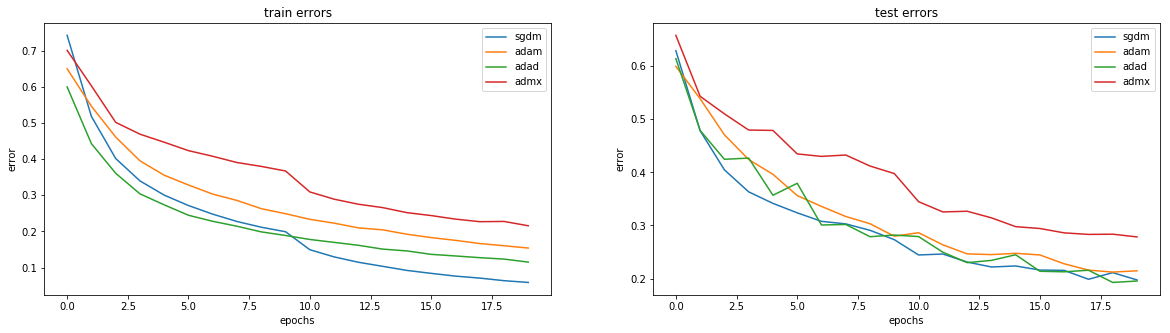

In [20]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,mynet2_err[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' errors')
        plt.xlabel('epochs')
        plt.ylabel('error')
plt.show()

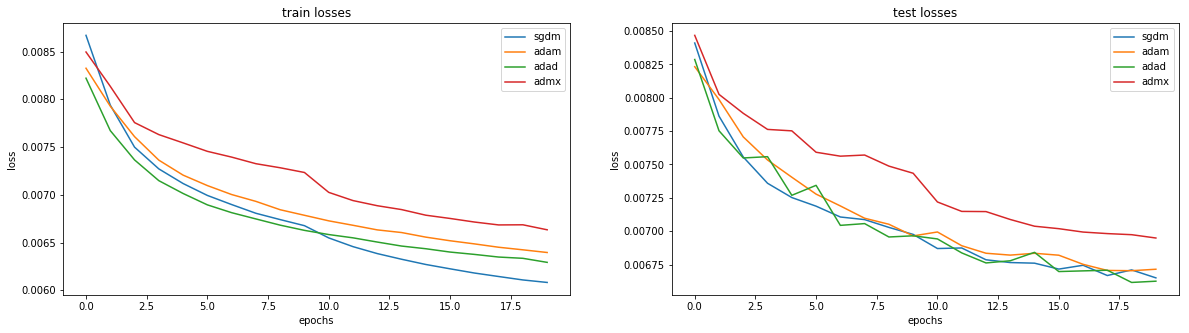

In [21]:
x = [i for i in range(epochs)]
plt.figure(figsize=(20,5))
for mode in ['train','test']:
    if mode=='train':
        plt.subplot('121')
    else:
        plt.subplot('122')
    for opt in ['sgdm','adam','adad','admx']:
        plt.plot(x,mynet2_losses[mode][opt])
        plt.legend(['sgdm','adam','adad','admx'])
        plt.title(mode+' losses')
        plt.xlabel('epochs')
        plt.ylabel('loss')
plt.show()

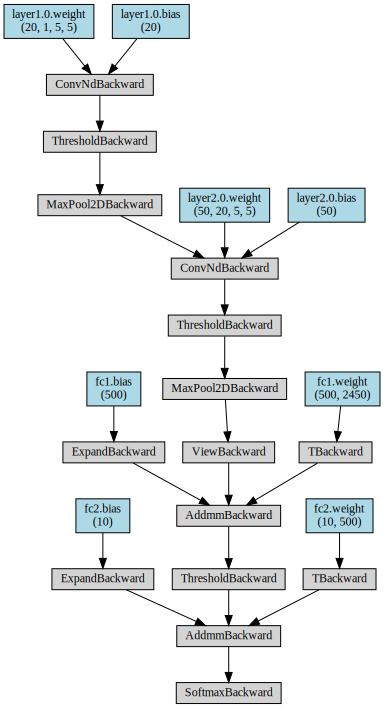

In [18]:
lenet = LeNet()
x = Variable(torch.randn(1,1,28,28))
y = lenet(x)
make_dot(y, params=dict(lenet.named_parameters()))

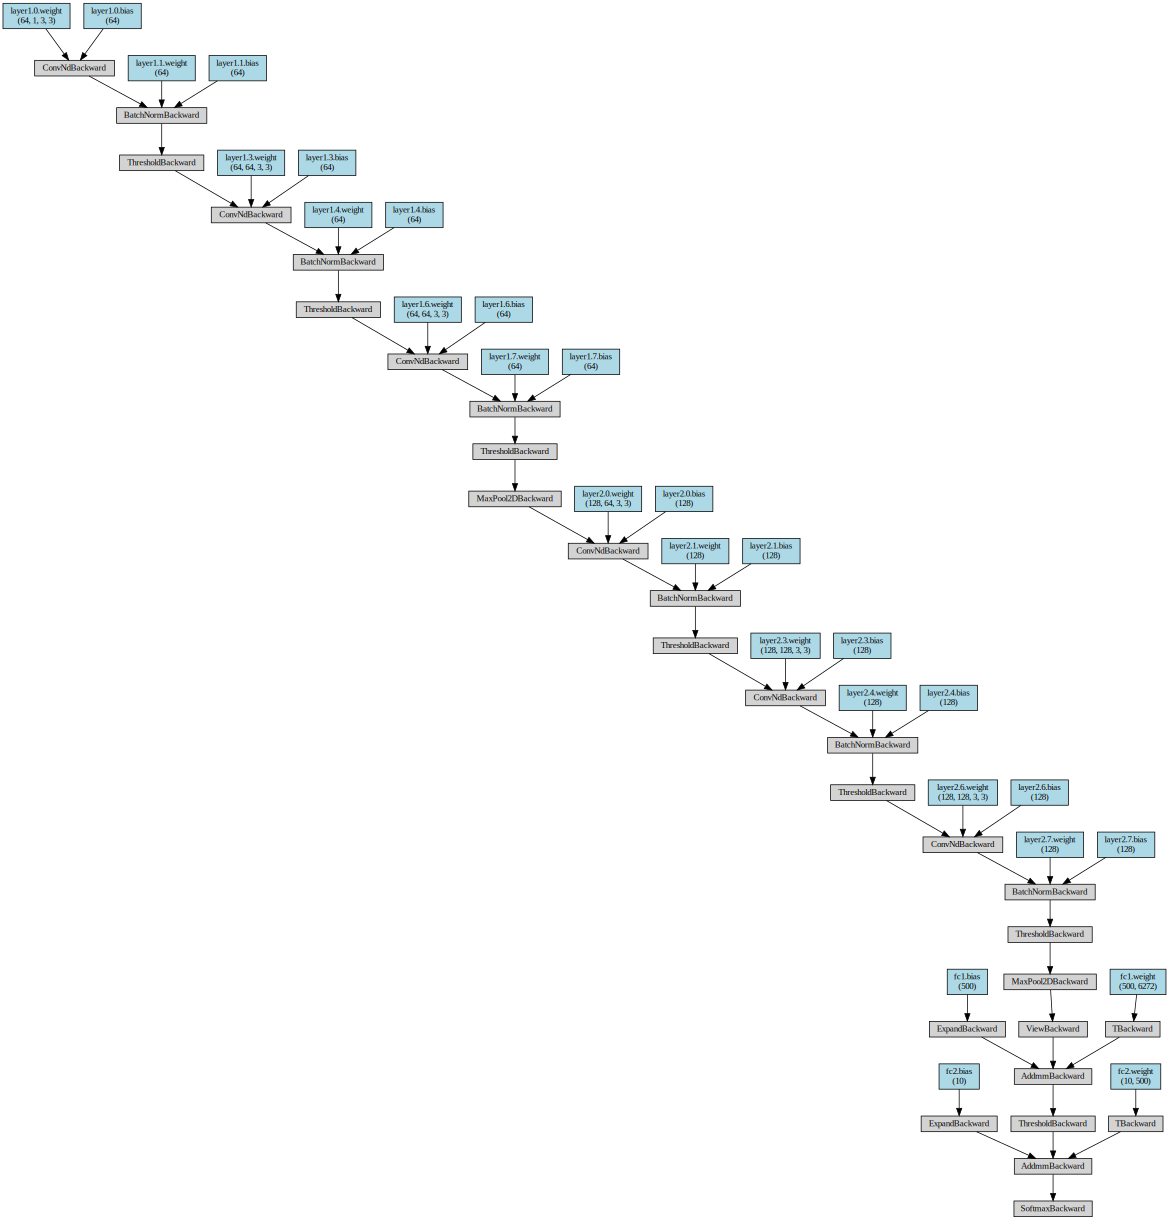

In [19]:
mynet = MyNet()
x = Variable(torch.randn(1,1,28,28))
y = mynet(x)
make_dot(y, params=dict(mynet.named_parameters()))

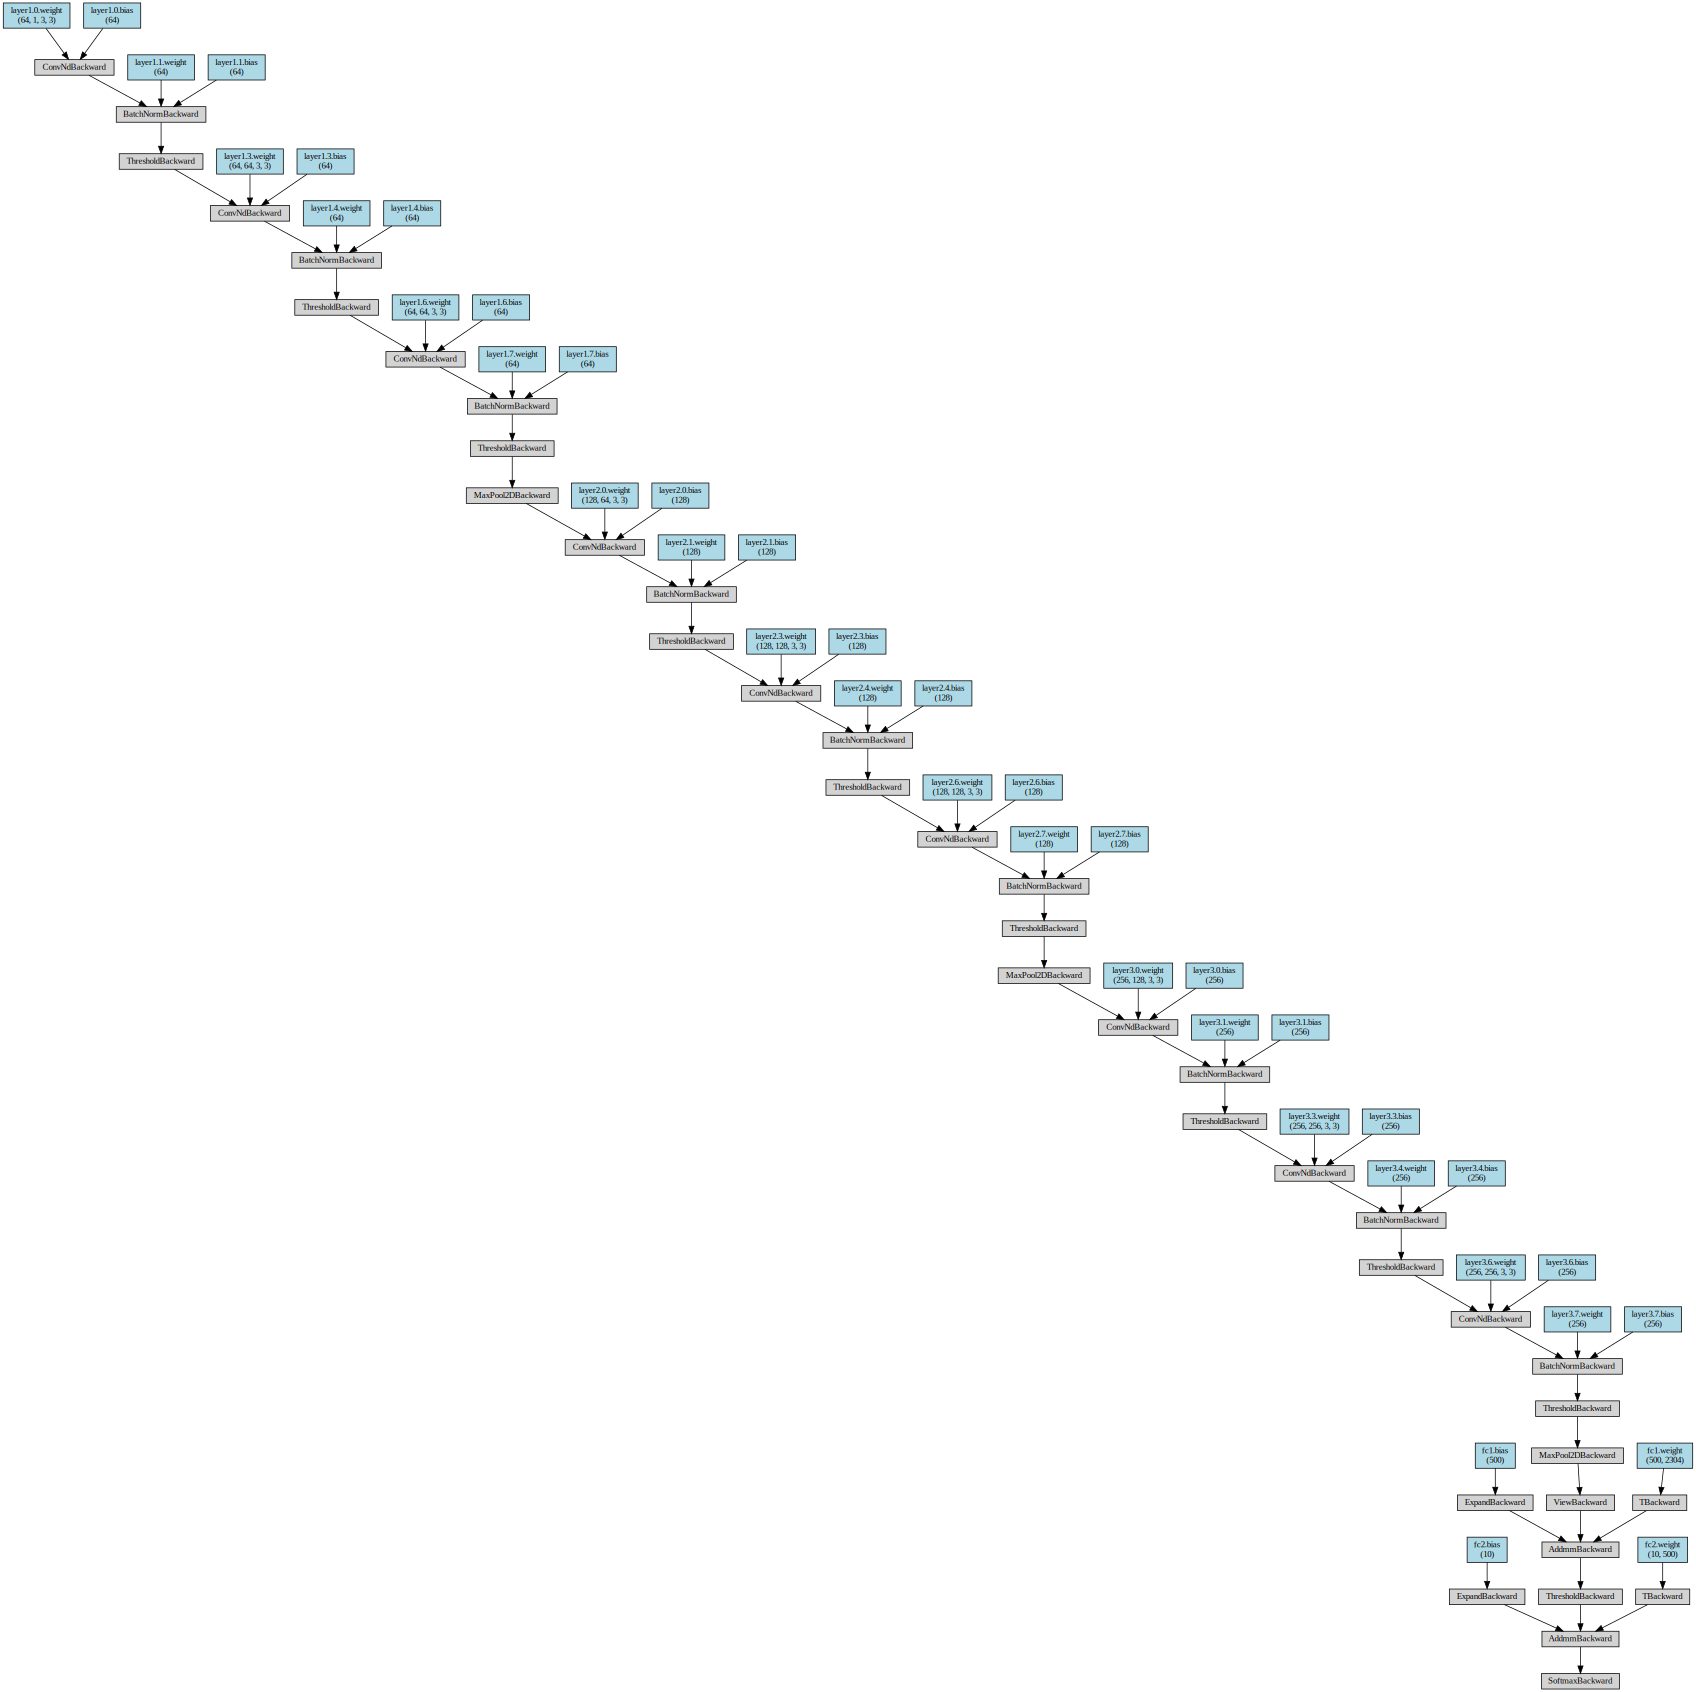

In [21]:
mynet2 = MyNet2()
x = Variable(torch.randn(1,1,28,28))
y = mynet2(x)
make_dot(y, params=dict(mynet2.named_parameters()))